In [1]:
from plots.mpltoolkit import named_colors, mpl_loc, markers, fancy_legend, load_style_sheet
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from scipy.stats import linregress
import numpy as np
import random
import vice
import sys
sys.path.append("..")
from src.stats import skewnormal_mode_sample, jackknife_summary_statistic
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [2]:
columns = ["LINE", "APOGEE_ID", "RA", "DEC", "GALR", "GALPHI", "GALZ", "SNREV", "TEFF", "TEFF_ERR",
    "LOGG", "LOGG_ERR", "FE_H", "FE_H_ERR", "O_FE", "O_FE_ERR", "ASTRONN_AGE", "ASTRONN_AGE_ERR",
    "LATENT_AGE", "LATENT_AGE_ERR"]
raw = np.genfromtxt("../data/Leung2023.csv", delimiter = ',', skip_header = 1, usecols = range(len(columns)))
sample = {}
for i in range(len(columns)):
    sample[columns[i]] = [row[i] for row in raw]
sample["o_h"] = [a + b for a, b in zip(sample["O_FE"], sample["FE_H"])]
sample["o_h_err"] = [np.sqrt(a**2 + b**2) for a, b in zip(sample["O_FE_ERR"], sample["FE_H_ERR"])]
sample["absz"] = [abs(_) for _ in sample["GALZ"]]
sample = vice.dataframe(sample)
# sample = sample.filter("absz", "<=", 0.5)
print(sample)

vice.dataframe{
    line -----------> [0, 1, 2, ... , 192917, 192918, 192919]
    apogee_id ------> [nan, nan, nan, ... , nan, nan, nan]
    ra -------------> [0.00285, 0.005558, 0.008802, ... , 359.993, 359.995, 359.997]
    dec ------------> [57.1732, 57.3545, 63.4631, ... , 57.0124, 57.435, 56.1633]
    galr -----------> [8.4584, 11.9539, 12.8583, ... , 10.6942, 9.3281, 9.64501]
    galphi ---------> [175.658, 153.655, 151.397, ... , 159.022, 167.511, 165.095]
    galz -----------> [-0.040749, -0.470835, 0.169356, ... , -0.358826, -0.163006, -0.265258]
    snrev ----------> [282.746, 120.295, 169.02, ... , 101.537, 232.918, 88.4561]
    teff -----------> [5031.26, 4974.6, 4681.46, ... , 4954.17, 4859.91, 4585.41]
    teff_err -------> [10.1451, 15.3109, 8.76634, ... , 15.7503, 9.05073, 11.2989]
    logg -----------> [3.45613, 2.38825, 2.24553, ... , 2.47466, 2.48069, 2.57144]
    logg_err -------> [0.0235541, 0.0355173, 0.0243345, ... , 0.0347484, 0.0240131, 0.0286862]
    fe_h ----

R = 3 - 5 kpc
R = 5 - 7 kpc
R = 7 - 9 kpc
R = 9 - 11 kpc
R = 11 - 13 kpc


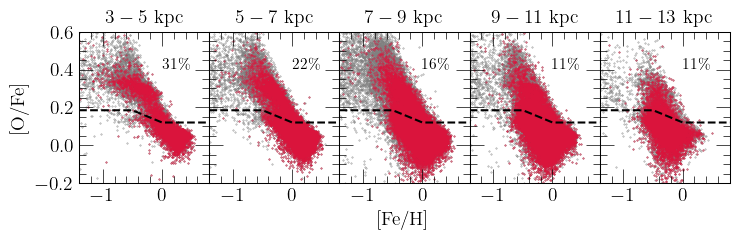

In [3]:
RADIAL_BINS = [[3, 5], [5, 7], [7, 9], [9, 11], [11, 13]]

fig = plt.figure(figsize = (7.5, 2.5))
axes = []
for i in range(len(RADIAL_BINS)):
    axes.append(fig.add_subplot(101 + 10 * len(RADIAL_BINS) + i))
    axes[i].set_xlim([-1.4, 0.8])
    axes[i].set_ylim([-0.2, 0.6])
    axes[i].set_yticks([-0.2, 0, 0.2, 0.4, 0.6])
    if i:
        plt.setp(axes[-1].get_yticklabels(), visible = False)
    else:
        axes[i].set_ylabel(r"[O/Fe]")
    axes[i].set_title(r"$%d - %d$ kpc" % (RADIAL_BINS[i][0], RADIAL_BINS[i][1]))
axes[len(RADIAL_BINS) // 2].set_xlabel(r"[Fe/H]")

def griffith_classify(feh, mgfe):
    return int(mgfe >= griffith_cut(feh))

def griffith_cut(feh):
    if feh <= -0.5:
        return 0.185
    elif -0.5 < feh < 0:
        return 0.12 - 0.13 * feh
    else:
        return 0.12

def plot_subset(ax, rmin, rmax, abszmax, agemax, **kwargs):
    sub = sample.filter(
        "galr", ">=", rmin).filter(
        "galr", "<=", rmax).filter(
        "absz", "<=", abszmax).filter(
        "astronn_age", "<=", agemax)
    ax.scatter(sub["fe_h"], sub["o_fe"], rasterized = True, **kwargs)

def mark_fraction(ax, rmin, rmax, abszmax, agemax, **kwargs):
    sub = sample.filter(
        "galr", ">=", rmin).filter(
        "galr", "<=", rmax).filter(
        "astronn_age", "<=", agemax).filter(
        "absz", "<=", abszmax)
    N = len(sub["fe_h"])
    arr = [griffith_classify(feh, mgfe) for feh, mgfe in zip(sub["fe_h"], sub["o_fe"])]
    frac = 100 * sum(arr) / N
    # arr = [griffith_classify(feh, mgfe) for feh, mgfe in zip(sub["fe_h"], sub["o_fe"])]
    # frac = 100 * sum(arr) / len(sub["fe_h"])
    # N = len(sub["fe_h"])
    # sub = sub.filter(
    #     "absz", "<=", abszmax)
    # frac = 100 * (1 - len(sub["fe_h"]) / N)
    ax.text(0., 0.4, r"$%d$\%%" % (int(frac)), **kwargs)

for i in range(len(RADIAL_BINS)):
    print("R = %d - %d kpc" % (RADIAL_BINS[i][0], RADIAL_BINS[i][1]))
    kwargs = {
        "c": named_colors()["grey"],
        "s": 0.1
    }
    plot_subset(axes[i], RADIAL_BINS[i][0], RADIAL_BINS[i][1], 100, 100, **kwargs)
    kwargs["c"] = named_colors()["crimson"]
    plot_subset(axes[i], RADIAL_BINS[i][0], RADIAL_BINS[i][1], 0.5, 10, **kwargs)
    mark_fraction(axes[i], RADIAL_BINS[i][0], RADIAL_BINS[i][1], 0.5, 10, fontsize = 11)

for i in range(len(axes)):
    xvals = np.linspace(axes[i].get_xlim()[0], axes[i].get_xlim()[1], 1000)
    yvals = [griffith_cut(x) for x in xvals]
    axes[i].plot(xvals, yvals, c = named_colors()["black"], linestyle = "--")

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./referee/ofe-feh.%s" % (ext), **kwargs)
plt.show()